# Bitcoin Trading Algorithm: Demo

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

In [12]:
BTC_USD=yf.download("BTC-USD", start = "2020-01-01", end = "2022-12-31", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [13]:
BTC_USD.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,16919.804688,11886957804
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,16642.341797,14472237479
2022-12-30,16641.330078,16643.427734,16408.474609,16602.585938,16602.585938,15929162910


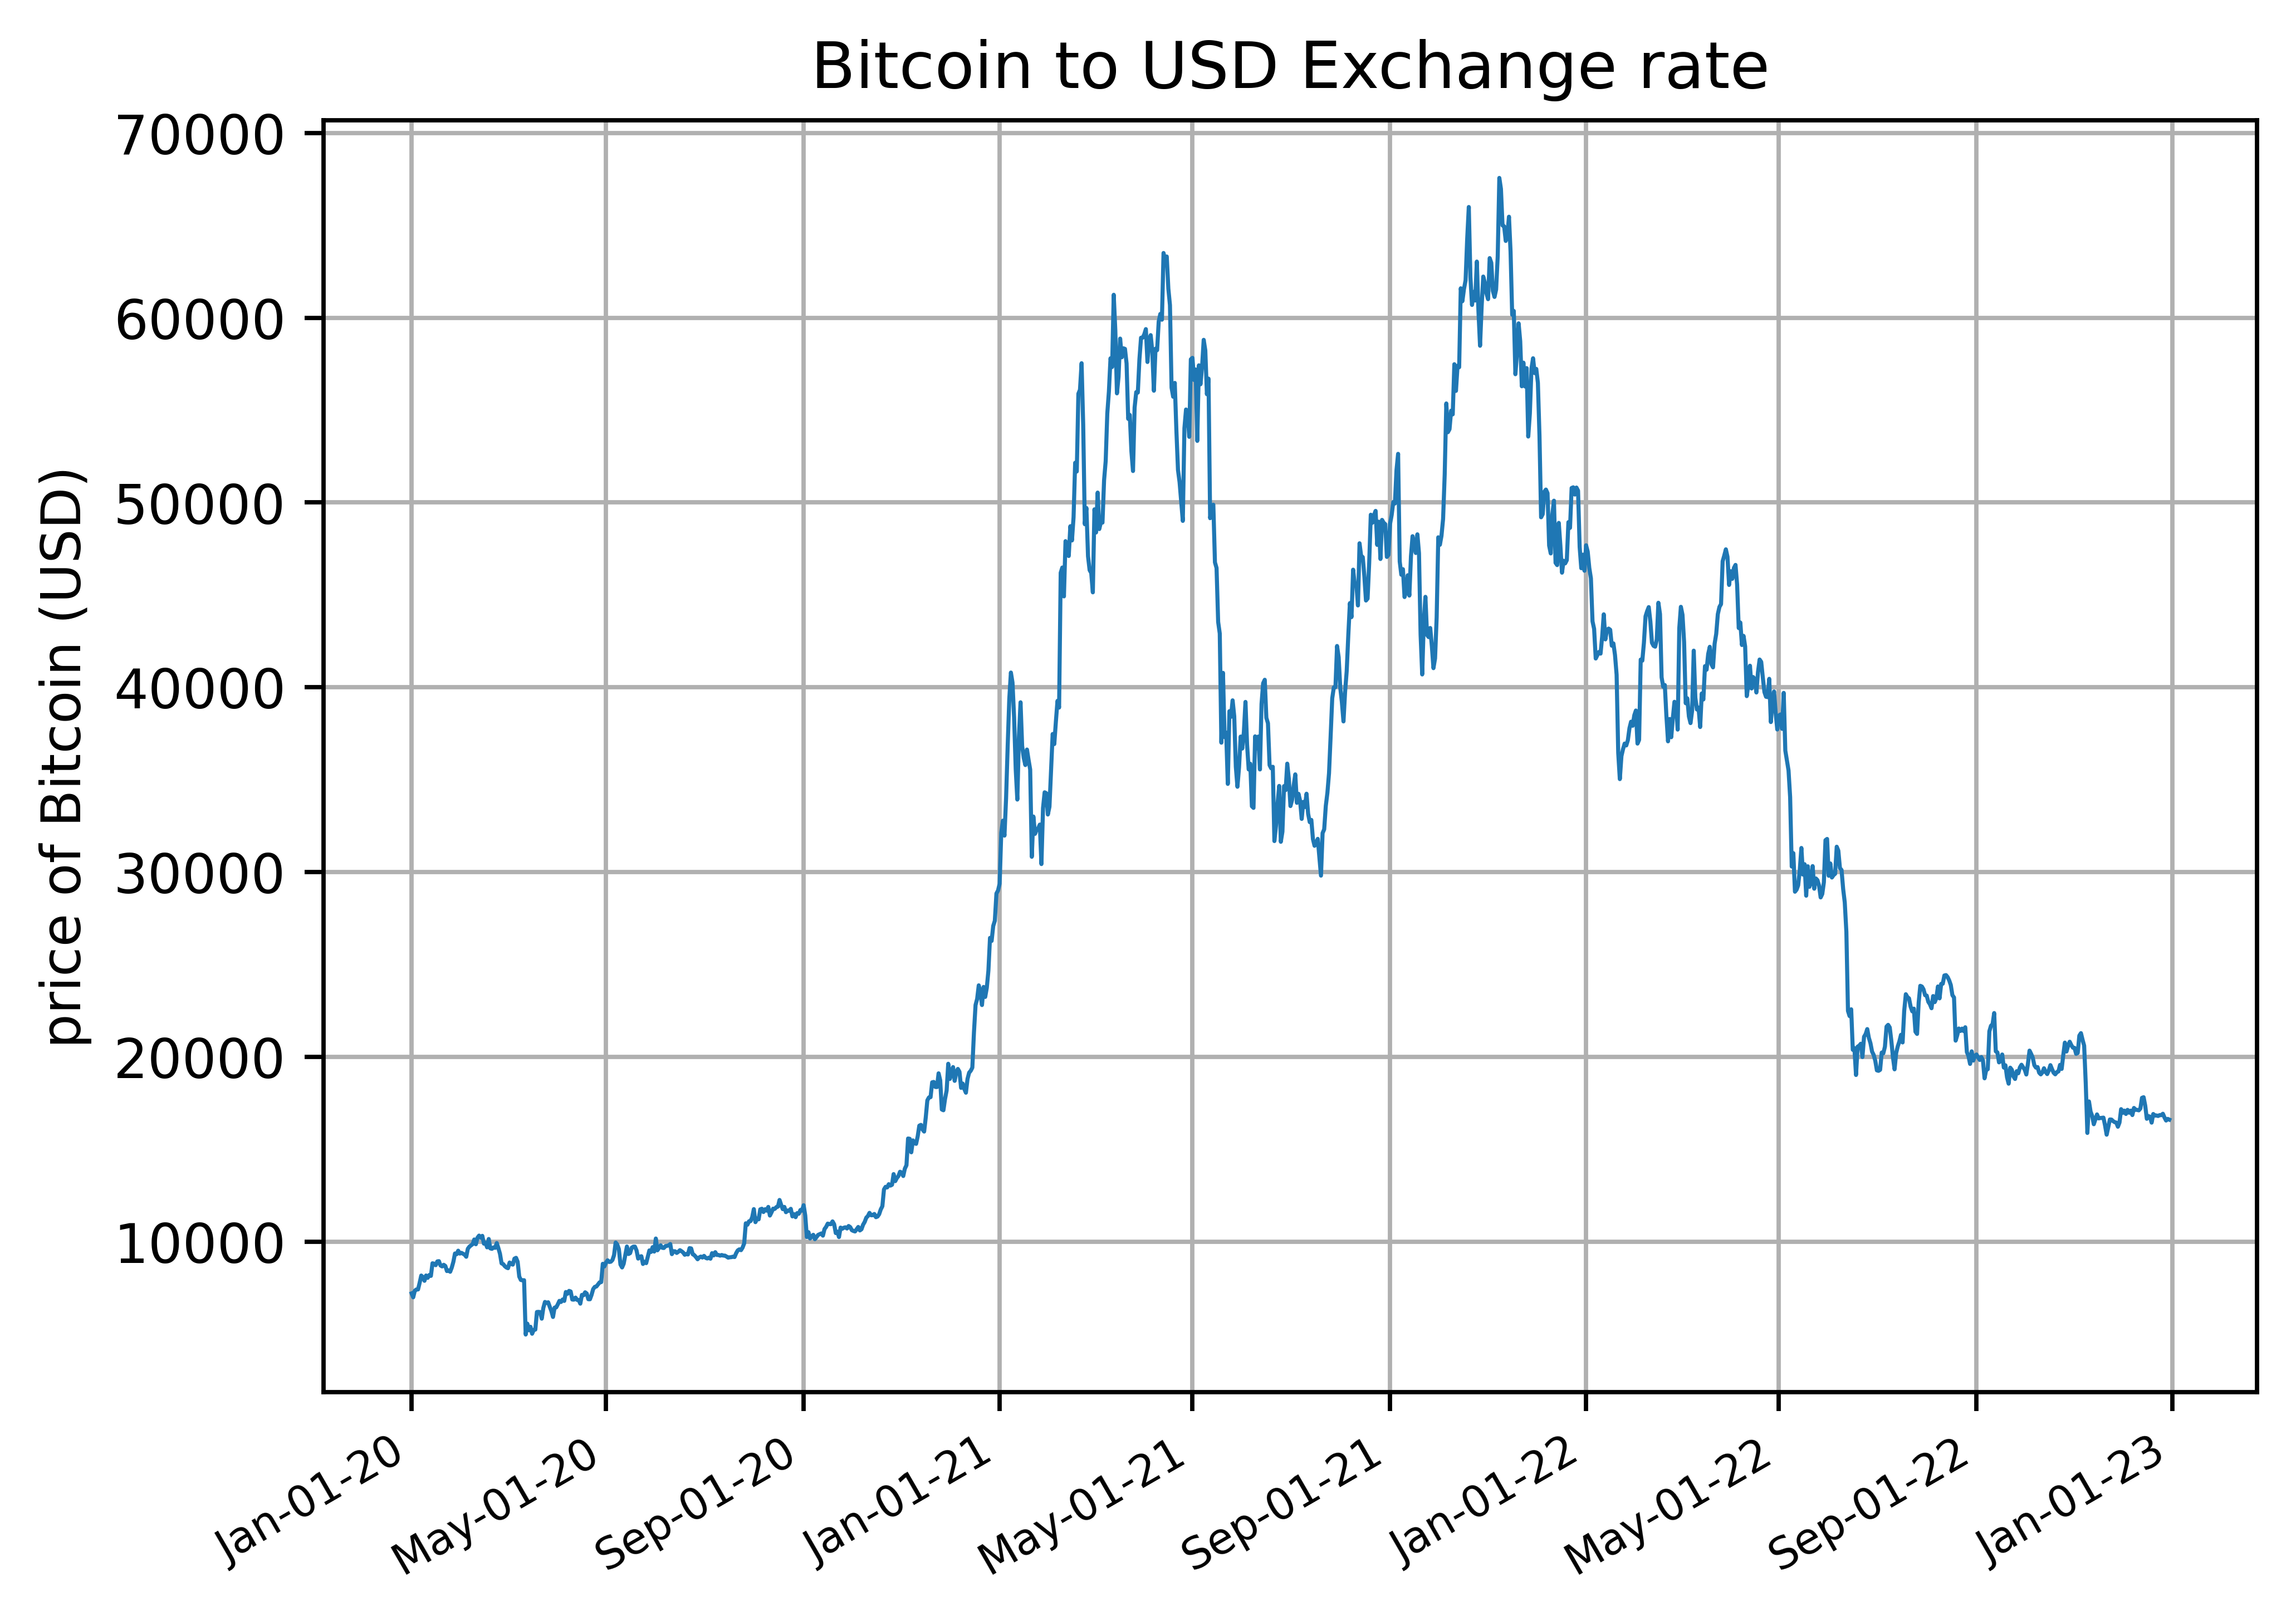

In [14]:
fig, ax=plt.subplots(dpi=700)

dateFormat = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(dateFormat)
ax.tick_params(axis='x',labelsize=8)
fig.autofmt_xdate()

ax.plot(BTC_USD['Close'], lw=0.75)

ax.set_ylabel("price of Bitcoin (USD)")
ax.set_title("Bitcoin to USD Exchange rate")
ax.grid()

plt.show()

In [15]:
BTC_USD['SMA_9']=BTC_USD['Close'].rolling(window=9, min_periods=1).mean()

In [16]:
BTC_USD.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA_9
Date,,,,,,,
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,16919.804688,11886957804,16795.370877
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239,16790.837240
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920,16803.380859
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,16642.341797,14472237479,16774.051649
2022-12-30,16641.330078,16643.427734,16408.474609,16602.585938,16602.585938,15929162910,16750.168403


In [17]:
BTC_USD['SMA_30']=BTC_USD['Close'].rolling(window=30, min_periods=1).mean()

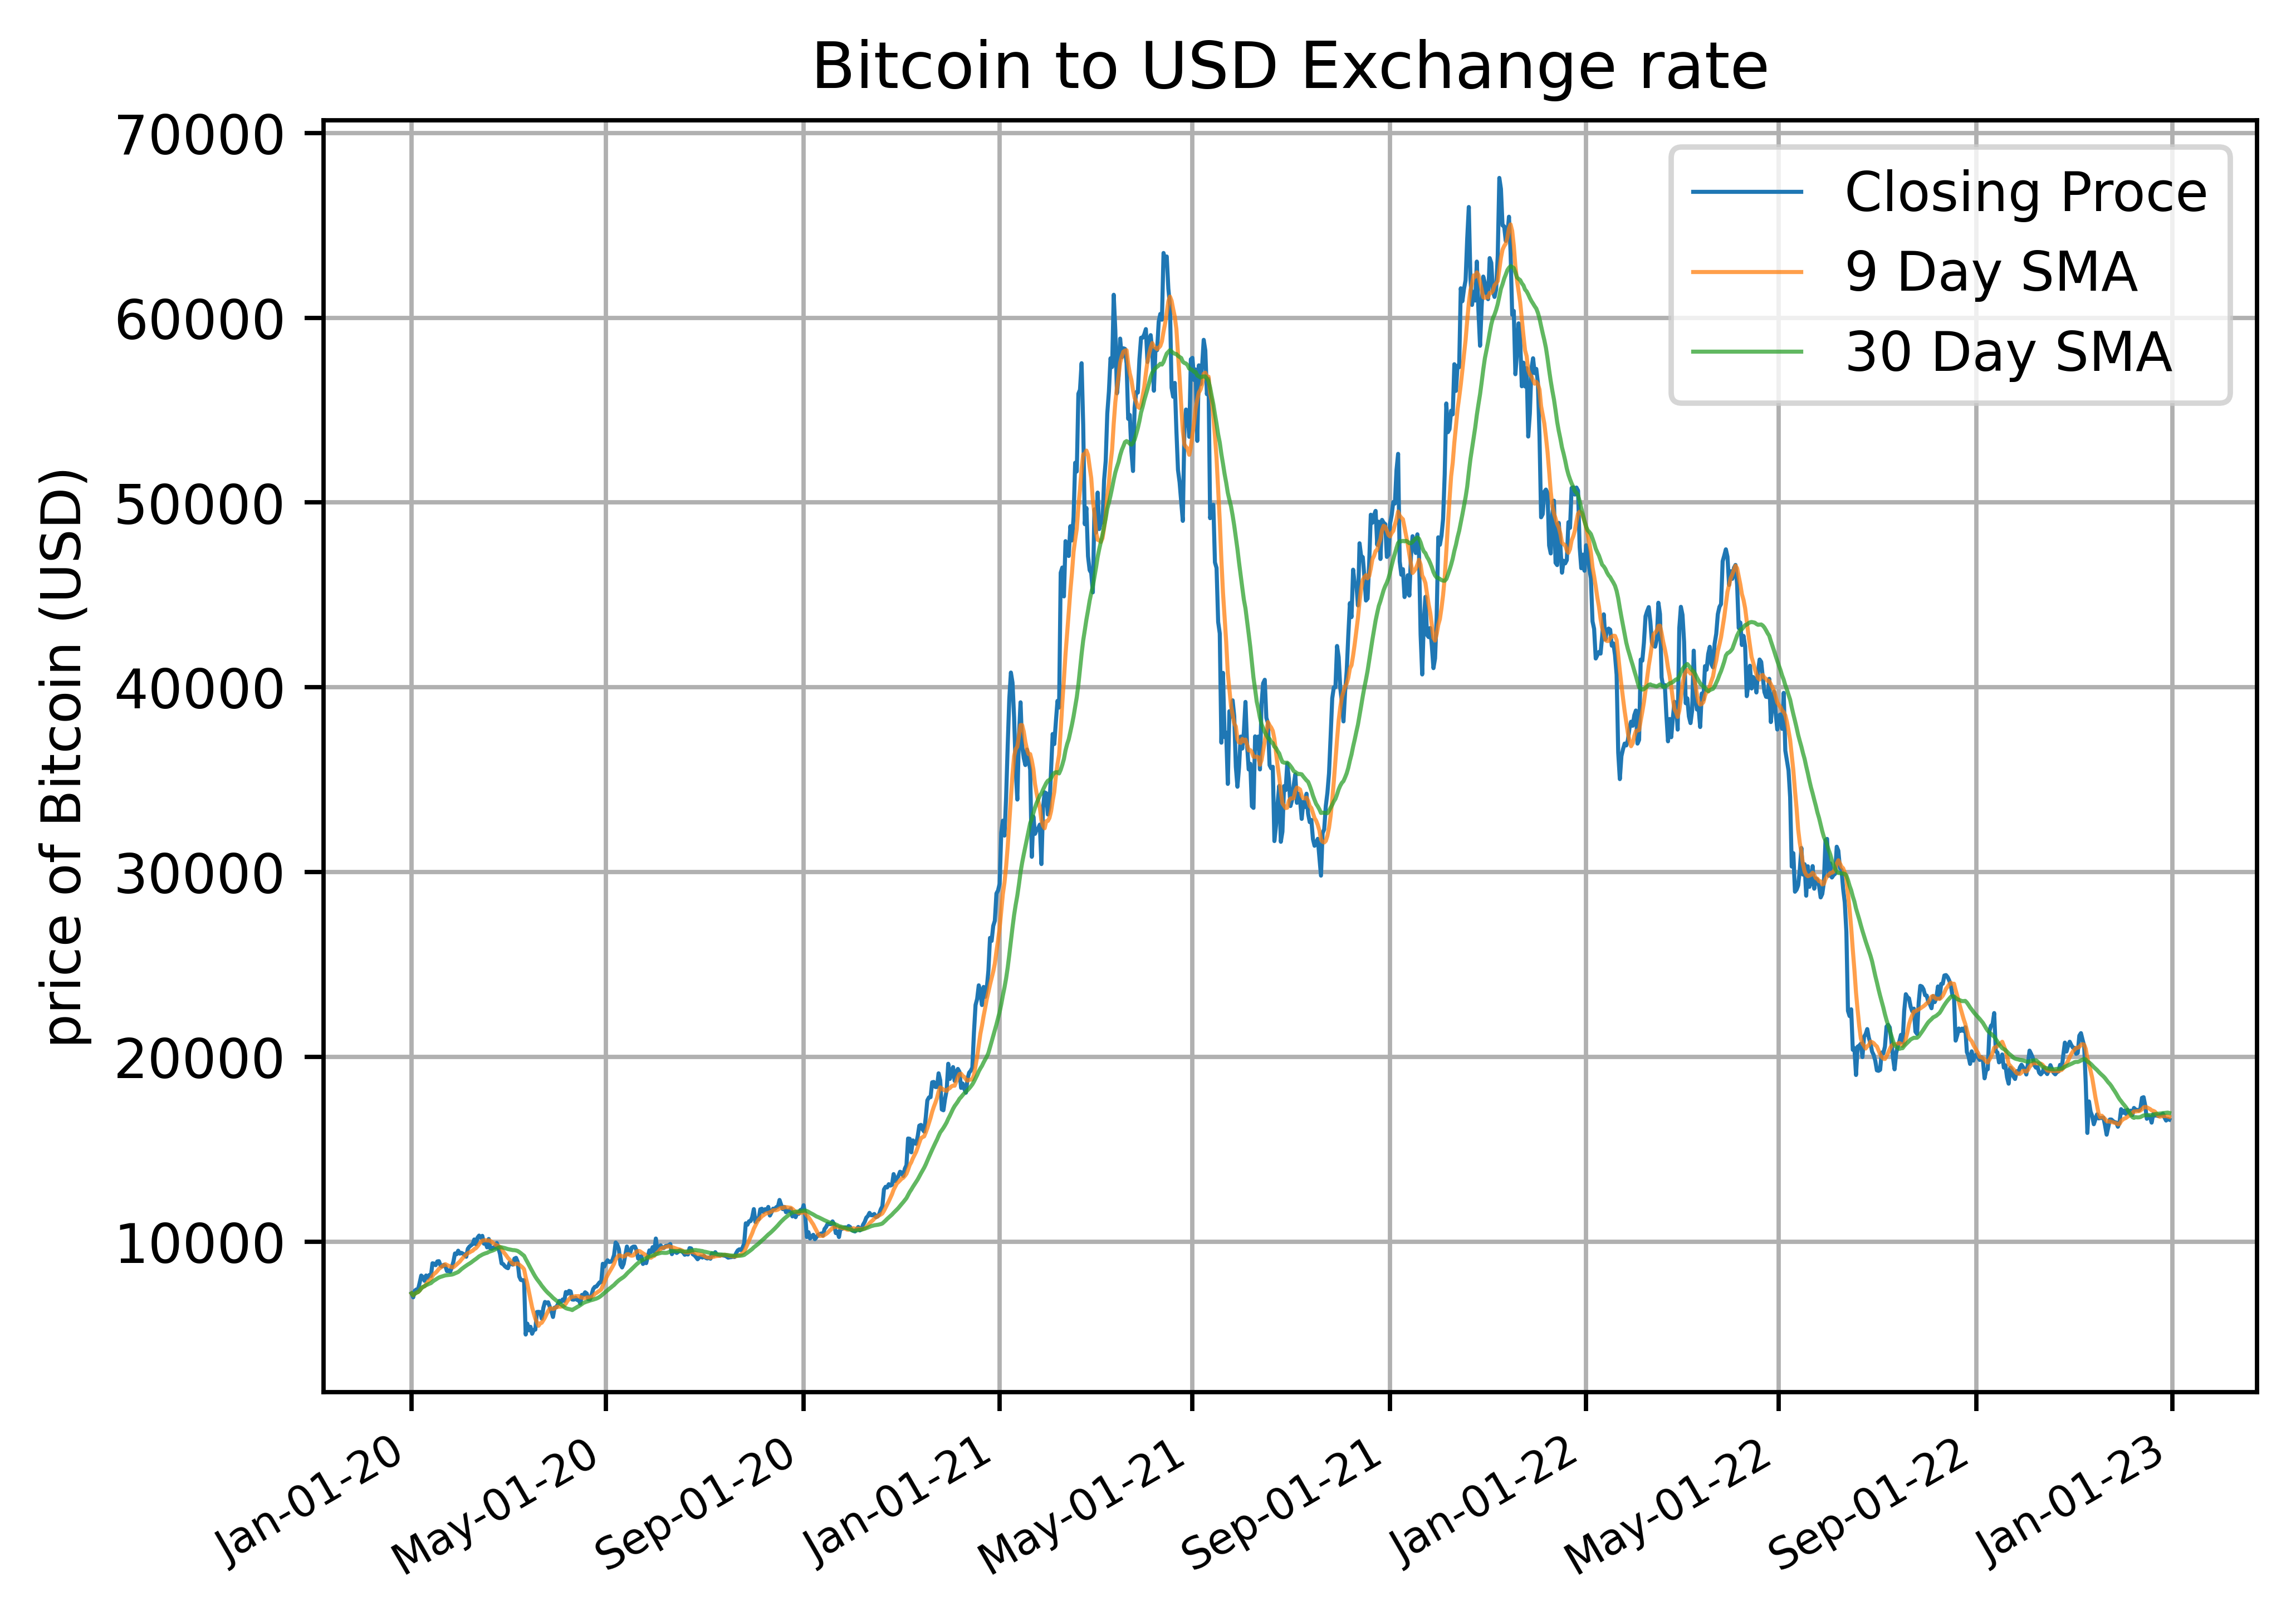

In [18]:
fig, ax=plt.subplots(dpi=700)

dateFormat = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(dateFormat)
ax.tick_params(axis='x',labelsize=8)
fig.autofmt_xdate()

ax.plot(BTC_USD['Close'], lw=0.75, label="Closing Proce")
ax.plot(BTC_USD['SMA_9'], lw=0.75, alpha=0.75, label='9 Day SMA')
ax.plot(BTC_USD['SMA_30'], lw=0.75, alpha=0.75, label='30 Day SMA')

ax.set_ylabel("price of Bitcoin (USD)")
ax.set_title("Bitcoin to USD Exchange rate")
ax.grid()
ax.legend()

plt.show()

In [19]:
trade_signals = pd.DataFrame(index=BTC_USD.index)

short_interval=10;
long_interval=40

trade_signals["Short"]=BTC_USD['Close'].rolling(window=short_interval, min_periods=1).mean()
trade_signals["Long"]=BTC_USD['Close'].rolling(window=long_interval, min_periods=1).mean()

In [20]:
trade_signals['Signal']=0.0

trade_signals["Signal"] = np.where(trade_signals['Short']>trade_signals['Long'], 1.0, 0.0)

In [21]:
trade_signals['Position'] = trade_signals['Signal'].diff()

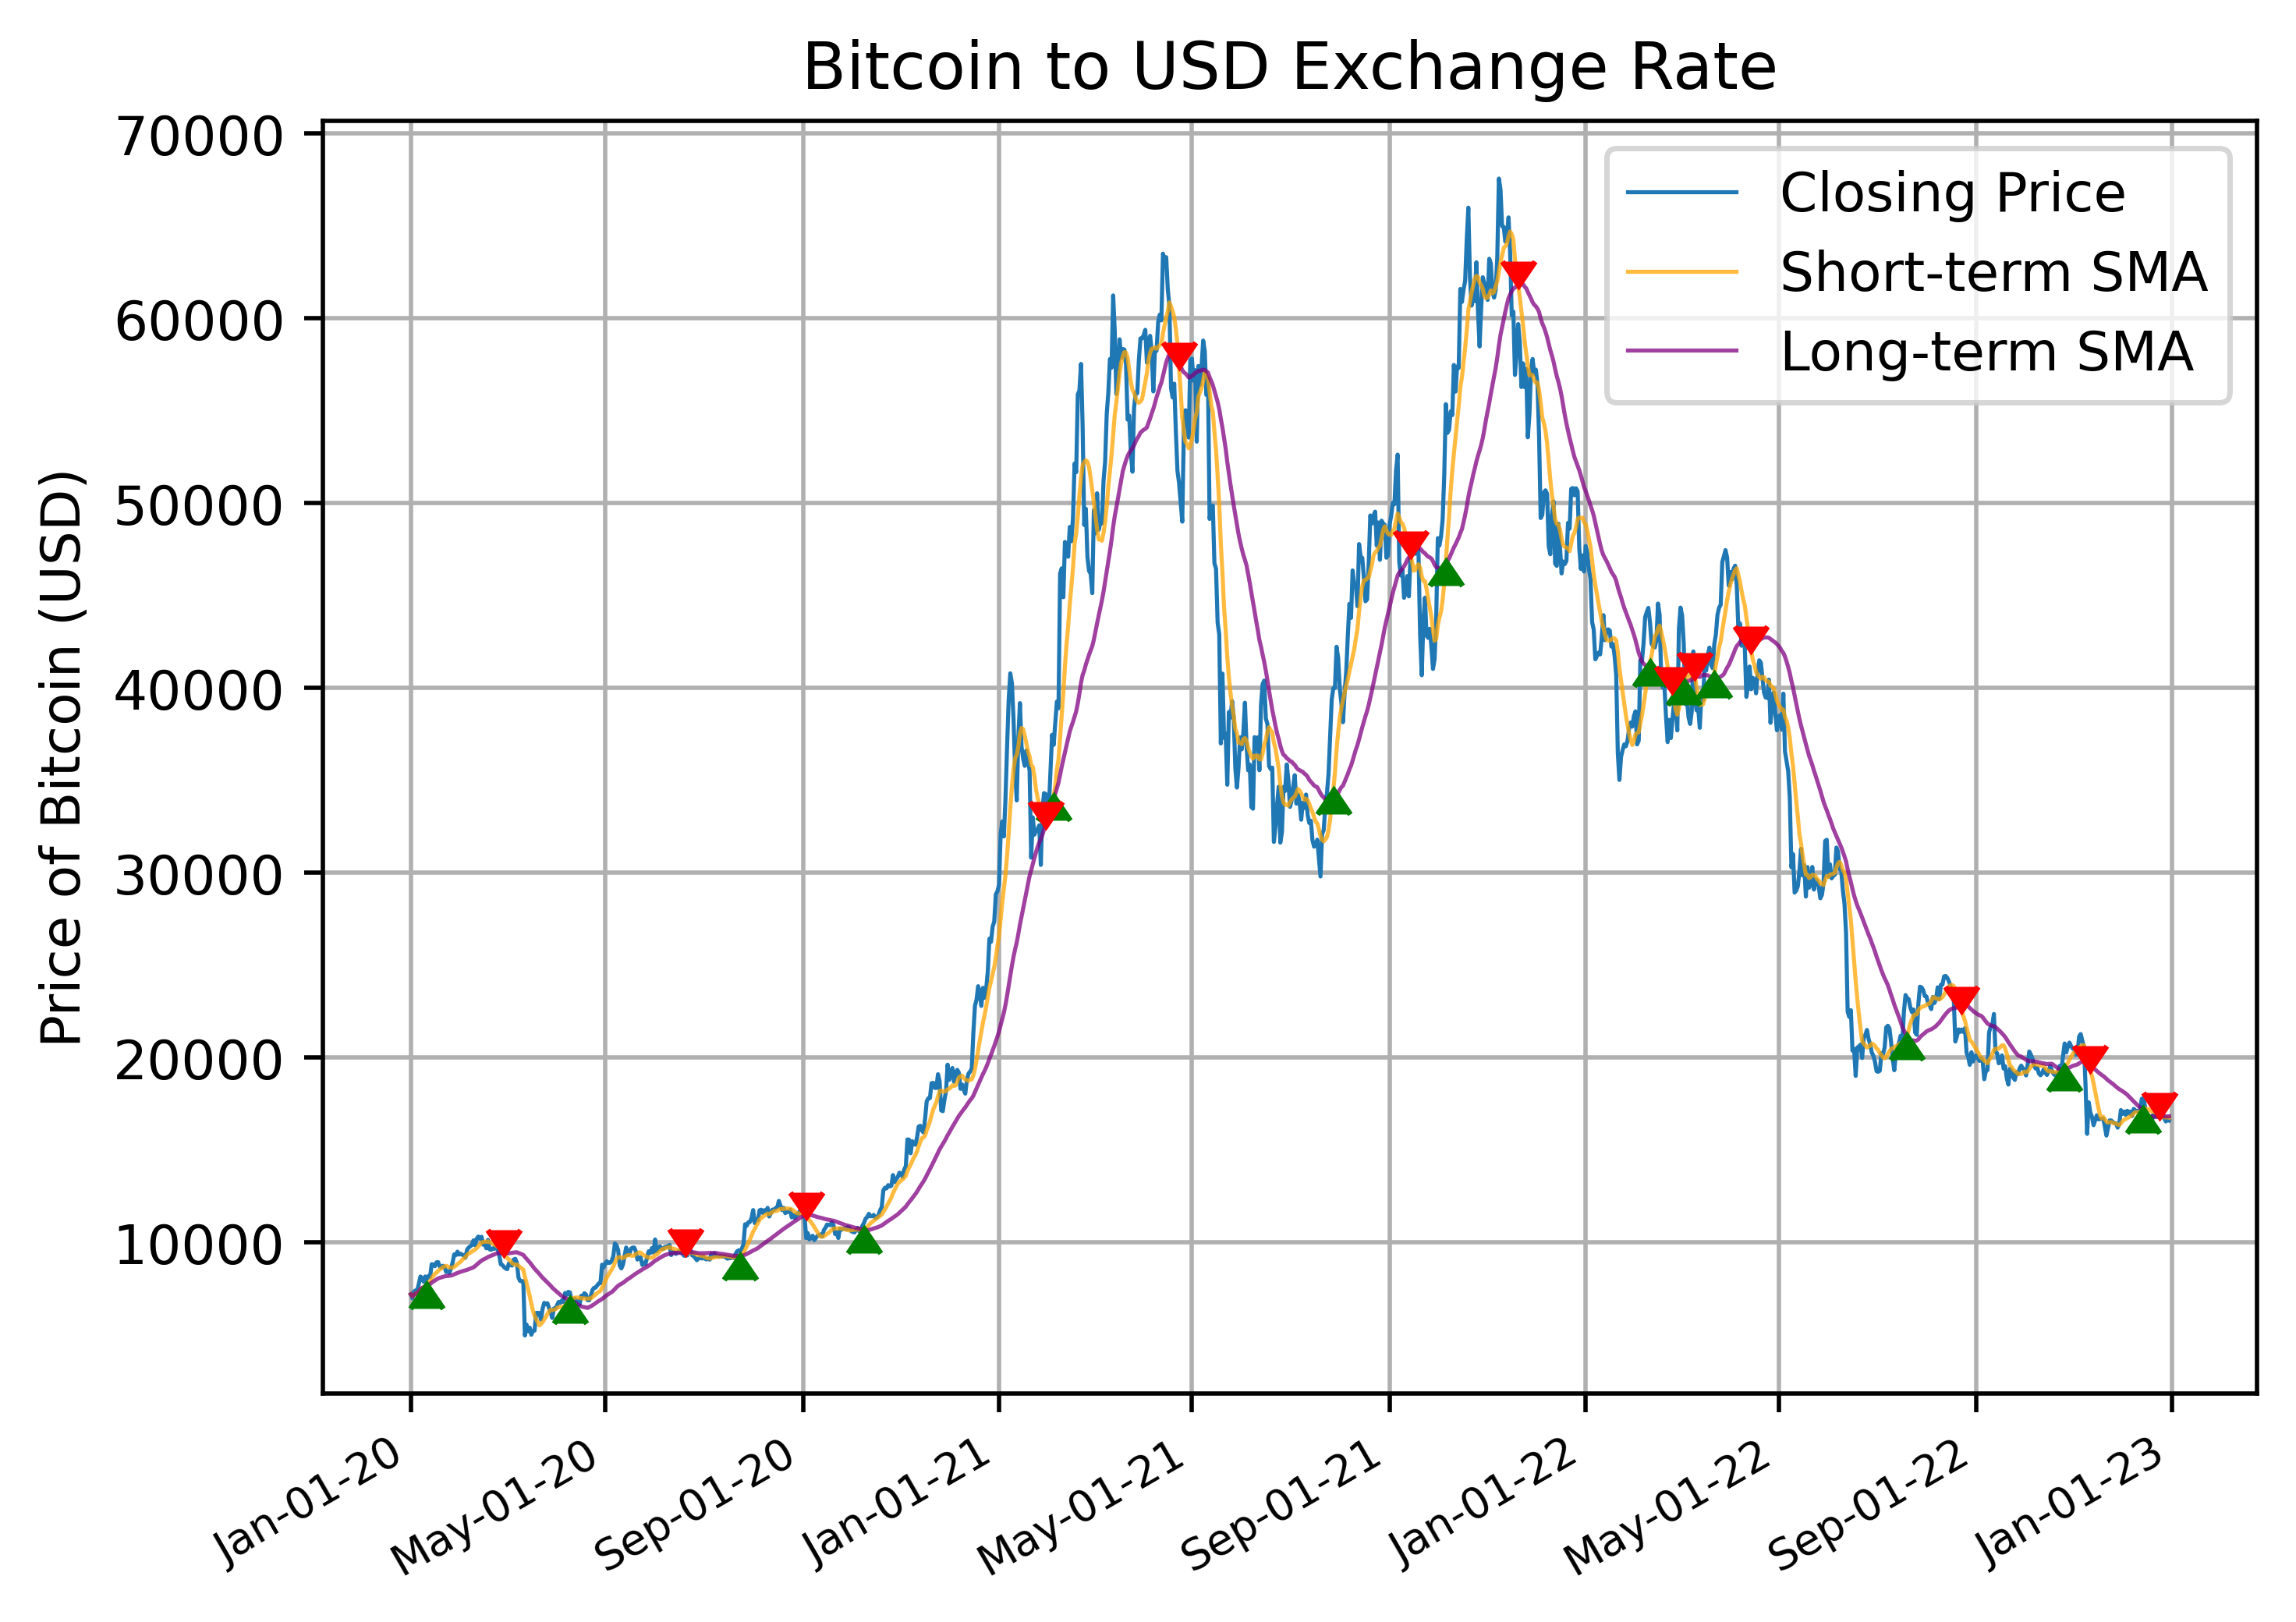

In [23]:
fig, ax = plt.subplots(dpi=500)

date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()


ax.plot(BTC_USD['Close'], lw=0.75, label="Closing Price")
#short term average
ax.plot(trade_signals['Short'], lw=0.75, alpha=0.75, color='orange', label='Short-term SMA')
#long term average
ax.plot(trade_signals['Long'], lw=0.75, alpha=0.75, color='purple', label='Long-term SMA')



#buy
ax.plot(trade_signals.loc[trade_signals['Position']==1.0].index, trade_signals.Short[trade_signals['Position'] == 1.0],
 marker=6, ms=6, linestyle='none', color='green')
#sell
ax.plot(trade_signals.loc[trade_signals['Position'] == -1.0].index, trade_signals.Short[trade_signals['Position'] == -1.0],
 marker=7, ms=6, linestyle='none', color='red')


ax.set_ylabel('Price of Bitcoin (USD)')
ax.set_title('Bitcoin to USD Exchange Rate')
ax.grid()
ax.legend() 

plt.show()

In [25]:
#backtest the algorithm 
"""general method for seeing how well a strategy or model would have done ex-post. 
Backtesting assesses the viability of a trading strategy by discovering how it would play out using historical data. 
If backtesting works, traders and analysts may have the confidence to employ it going forward."""

initial_balance=10000.0

backtest = pd.DataFrame(index=trade_signals.index)

#current closing price / yesterday's closing price
backtest['BTC_Return'] = BTC_USD['Close']/BTC_USD['Close'].shift(1)

#daily percent return
backtest['Alg_Return'] = np.where(trade_signals.Signal == 1, backtest.BTC_Return, 1.0)

#daily Value of portfolio using crossover strategy
backtest['Balance'] = initial_balance*backtest.Alg_Return.cumprod()

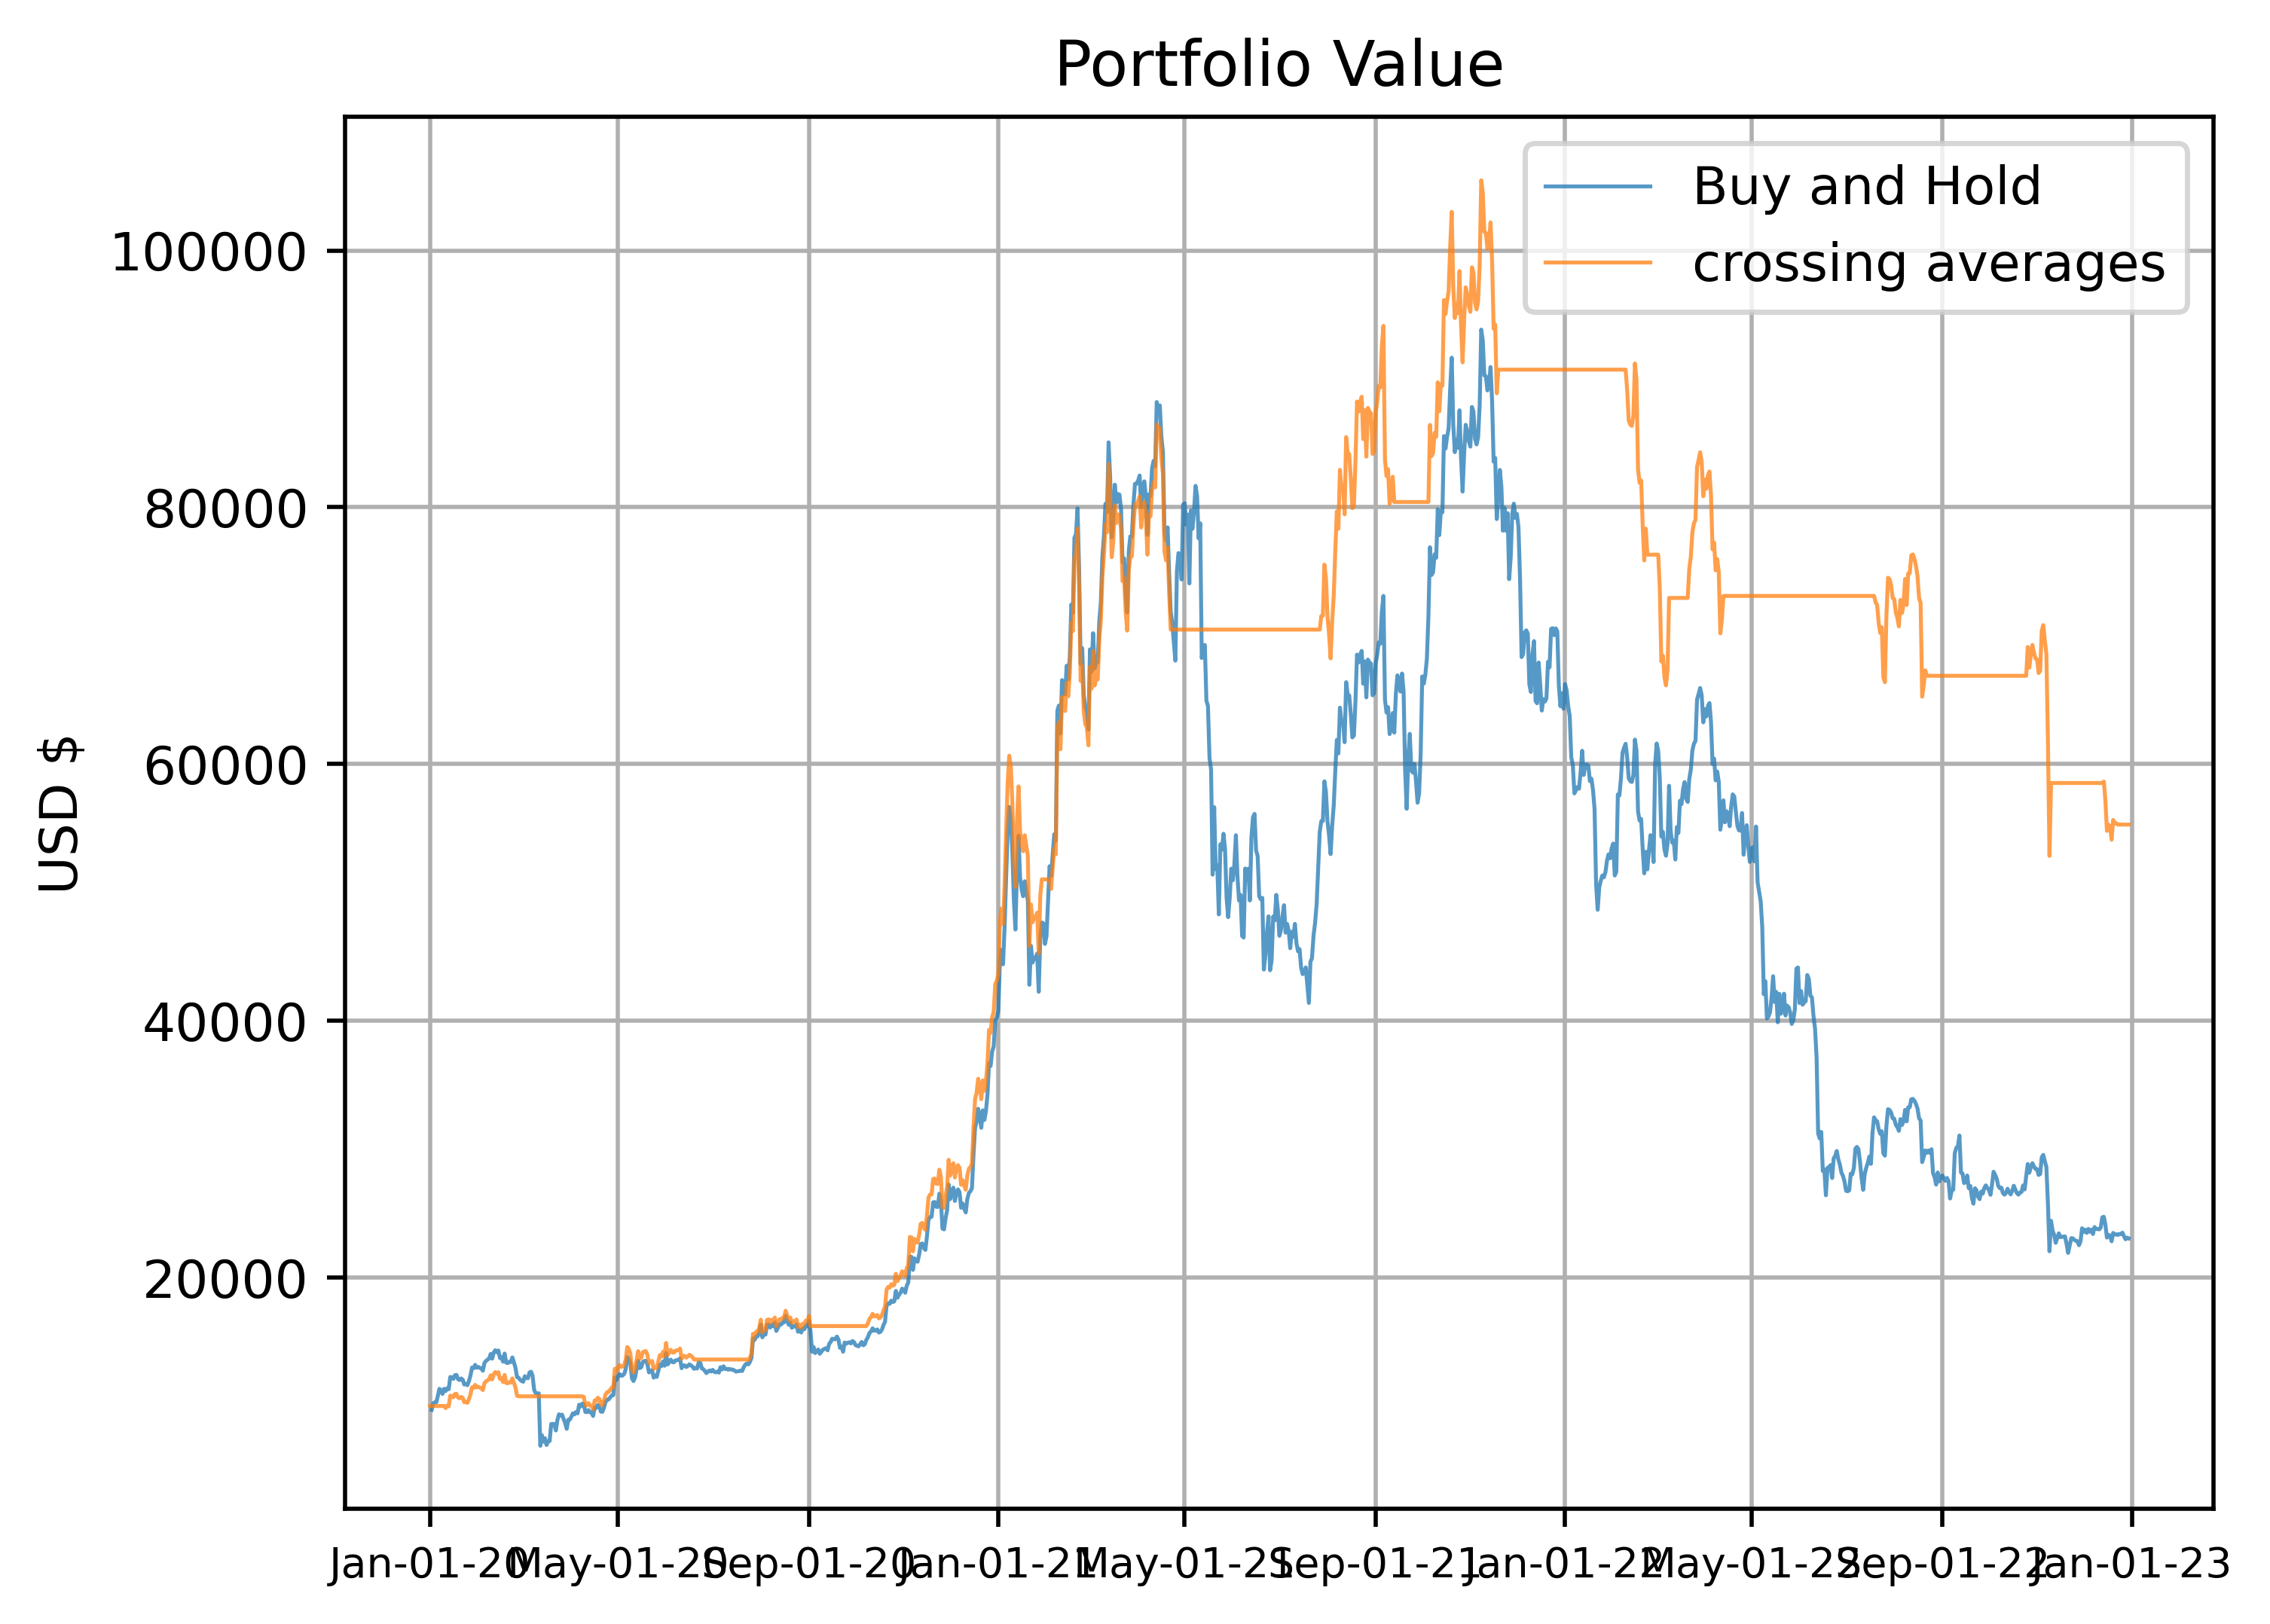

In [27]:
fig, ax = plt.subplots(dpi=500)

date_format = DateFormatter("%h-%d-%y")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)


#buy and hold strategies
ax.plot(initial_balance*backtest.BTC_Return.cumprod(), lw=0.75, alpha=0.75, label='Buy and Hold')

#Total Value of Crossing Averages Strategy
ax.plot(backtest['Balance'], lw=0.75, alpha=0.75, label='crossing averages')

ax.set_ylabel('USD $')
ax.set_title('Portfolio Value')
ax.grid()
ax.legend()

plt.show()